In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [29]:
# Load the 10 folds into a list of DataFrames
datasets = [pd.read_csv(f"datasets/sound_features_fold{i}.csv") for i in range(1, 11)]

# Define the mapping of labels to numbers
labels_dict = {
    "air_conditioner": 0,
    "car_horn": 1,
    "children_playing": 2,
    "dog_bark": 3,
    "drilling": 4,
    "engine_idling": 5,
    "gun_shot": 6,
    "jackhammer": 7,
    "siren": 8,
    "street_music": 9
}
# Replace string labels with numeric labels in each fold DataFrame
for df in datasets:
    df["Label"] = df["Label"].replace(labels_dict)

# Check the updated labels in the first fold
datasets[0].head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_rolloff,spectral_flatness,rms,zero_crossing_rate,tempo,tempogram,Label
0,-374.44590,97.047250,9.259301,-17.928537,1.152152,-8.538063,-15.637719,-8.188658,-11.003868,1.985415,...,960.279319,1313.641864,22.421554,1763.516865,0.003240,0.079418,0.050405,[66.96428571],0.040491,3
1,-333.74377,133.216250,15.807837,-33.060143,-1.289476,-17.097427,-30.018026,-22.263353,-18.194607,4.316967,...,865.872849,1143.308567,23.852010,1420.634921,0.001789,0.087223,0.053943,[110.29411765],0.059969,3
2,-382.80362,68.959465,4.313661,-2.062933,3.721442,-5.117520,-8.518147,-1.823458,-4.410032,4.914453,...,1132.635828,1453.488132,21.033922,2213.789683,0.009837,0.052242,0.059059,[52.08333333],0.031151,3
3,-96.21553,87.579865,-52.939266,-5.229744,-16.976635,3.661066,-4.204170,10.106073,3.249916,10.754143,...,1801.149302,1495.233043,21.253521,3214.285714,0.039912,0.118702,0.158978,[170.45454545],0.115612,3
4,-217.80743,124.950710,21.462078,11.288554,-10.218013,0.942786,-1.060578,7.175950,0.728432,1.115492,...,1163.692856,1572.547755,20.424197,2396.515377,0.015071,0.070206,0.071091,[133.92857143],0.025050,6


In [30]:
for df in datasets:
    object_columns = df.select_dtypes(include=['object']).columns
    print(object_columns)

Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')


In [31]:
# Example: Check what type of obejct 'tempo' is
print(datasets[0]['tempo'].head())

0     [66.96428571]
1    [110.29411765]
2     [52.08333333]
3    [170.45454545]
4    [133.92857143]
Name: tempo, dtype: object


In [32]:
import ast  # For safely evaluating the string representation of lists

for df in datasets:
    # Convert the string representation of lists to actual lists
    df['tempo'] = df['tempo'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Now, extract the first value from the list (if it’s a list)
    df['tempo'] = df['tempo'].apply(lambda x: x[0] if isinstance(x, list) else x)

    # Convert the 'tempo' column to numeric
    df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')

    # Check for NaN values
    print(df['tempo'].isna().sum())  # Count of NaN values

    # Handle NaN values (optional)
    df['tempo'].fillna(df['tempo'].mean(), inplace=True)  # Fill NaNs with the mean
    # Alternatively, you could drop rows with NaNs: df.dropna(subset=['tempo'], inplace=True)
datasets[0].head()

0
0
0
0
0
0
0
0
0
0


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_rolloff,spectral_flatness,rms,zero_crossing_rate,tempo,tempogram,Label
0,-374.44590,97.047250,9.259301,-17.928537,1.152152,-8.538063,-15.637719,-8.188658,-11.003868,1.985415,...,960.279319,1313.641864,22.421554,1763.516865,0.003240,0.079418,0.050405,66.964286,0.040491,3
1,-333.74377,133.216250,15.807837,-33.060143,-1.289476,-17.097427,-30.018026,-22.263353,-18.194607,4.316967,...,865.872849,1143.308567,23.852010,1420.634921,0.001789,0.087223,0.053943,110.294118,0.059969,3
2,-382.80362,68.959465,4.313661,-2.062933,3.721442,-5.117520,-8.518147,-1.823458,-4.410032,4.914453,...,1132.635828,1453.488132,21.033922,2213.789683,0.009837,0.052242,0.059059,52.083333,0.031151,3
3,-96.21553,87.579865,-52.939266,-5.229744,-16.976635,3.661066,-4.204170,10.106073,3.249916,10.754143,...,1801.149302,1495.233043,21.253521,3214.285714,0.039912,0.118702,0.158978,170.454545,0.115612,3
4,-217.80743,124.950710,21.462078,11.288554,-10.218013,0.942786,-1.060578,7.175950,0.728432,1.115492,...,1163.692856,1572.547755,20.424197,2396.515377,0.015071,0.070206,0.071091,133.928571,0.025050,6


In [33]:
for df in datasets:
    object_columns = df.select_dtypes(include=['object']).columns
    print(object_columns)

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


In [34]:
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Processing Fold 1...


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1138 - loss: 2.6965 - val_accuracy: 0.2984 - val_loss: 2.1814
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2372 - loss: 2.1857 - val_accuracy: 0.3750 - val_loss: 1.9751
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3212 - loss: 1.9888 - val_accuracy: 0.4088 - val_loss: 1.8251
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3806 - loss: 1.8334 - val_accuracy: 0.4459 - val_loss: 1.7461
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4042 - loss: 1.7547 - val_accuracy: 0.4662 - val_loss: 1.7119
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4408 - loss: 1.6628 - val_accuracy: 0.4696 - val_loss: 1.6906
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4732 - loss: 1.5797 - val_accuracy: 0.4944 - val_loss: 1.6706
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4805 - loss: 1.5522 - val_accuracy: 0.5079 - val_loss:

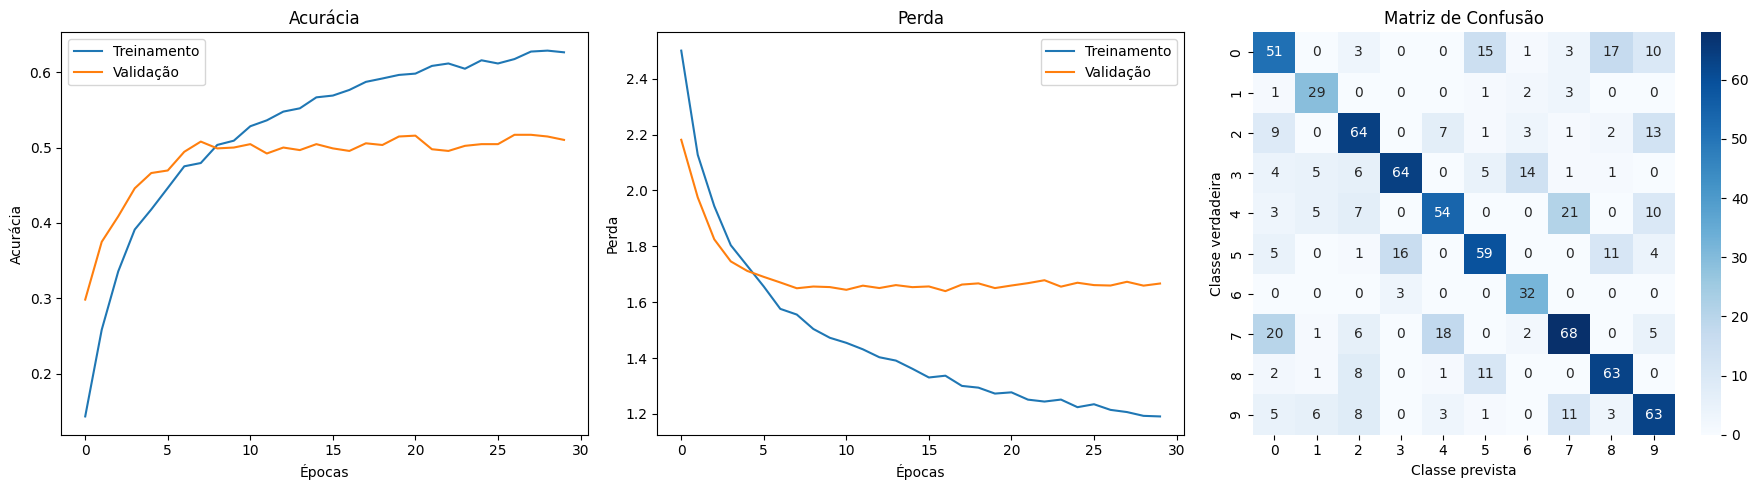

Fold 1: Test accuracy: 0.6266
Processing Fold 2...
Epoch 1/30


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1248 - loss: 2.6345 - val_accuracy: 0.2465 - val_loss: 2.2180
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2476 - loss: 2.1729 - val_accuracy: 0.3146 - val_loss: 2.0492
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3257 - loss: 1.9814 - val_accuracy: 0.3589 - val_loss: 1.9266
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3860 - loss: 1.8272 - val_accuracy: 0.3859 - val_loss: 1.8558
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4143 - loss: 1.7370 - val_accuracy: 0.4151 - val_loss: 1.8139
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4419 - loss: 1.6591 - val_accuracy: 0.4432 - val_loss: 1.7642
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4592 - loss: 1.6007 - val_accuracy: 0.4486 - val_loss: 1.7408
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4842 - loss: 1.5530 - val_accuracy: 0.4627 - val_loss: 1.7131
Epo

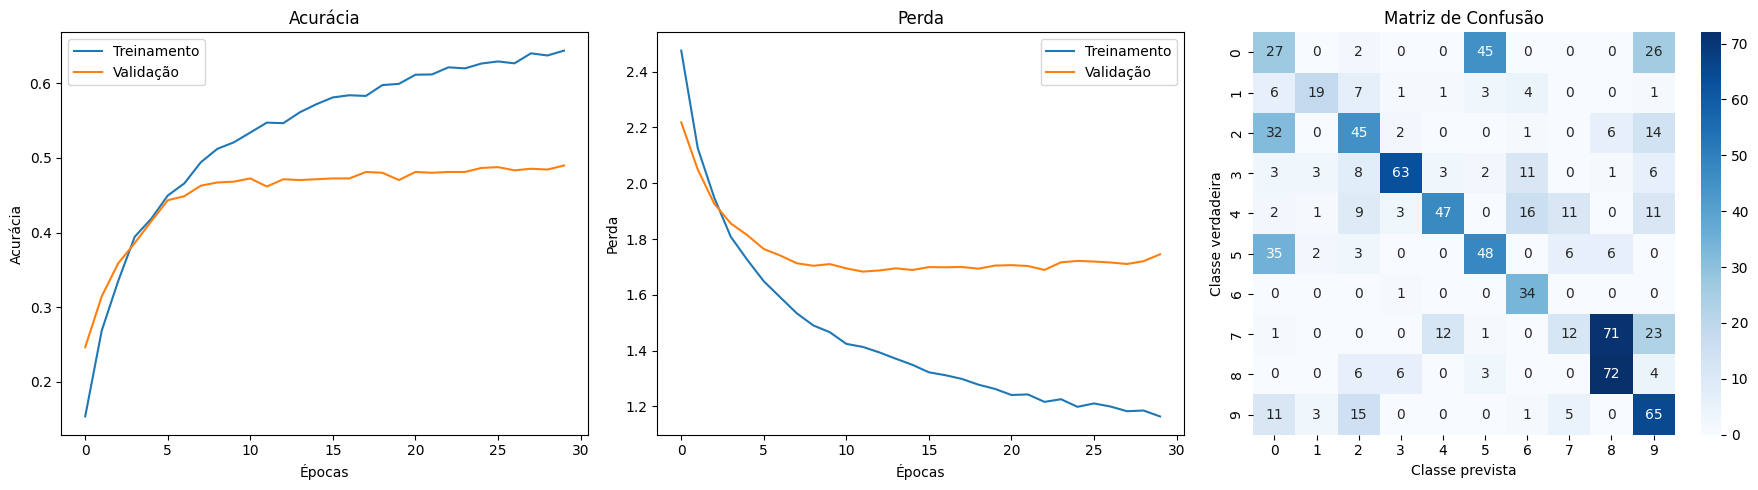

Fold 2: Test accuracy: 0.4865
Processing Fold 3...
Epoch 1/30


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1166 - loss: 2.7262 - val_accuracy: 0.3626 - val_loss: 2.1947
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2271 - loss: 2.2384 - val_accuracy: 0.4162 - val_loss: 2.0312
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3099 - loss: 2.0381 - val_accuracy: 0.4374 - val_loss: 1.8705
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3729 - loss: 1.8855 - val_accuracy: 0.4444 - val_loss: 1.7549
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4017 - loss: 1.7809 - val_accuracy: 0.4424 - val_loss: 1.6831
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4158 - loss: 1.6981 - val_accuracy: 0.4394 - val_loss: 1.6293
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4819 - loss: 1.5942 - val_accuracy: 0.4364 - val_loss: 1.5909
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4891 - loss: 1.5480 - val_accuracy: 0.4525 - val_loss: 1.5822
Epo

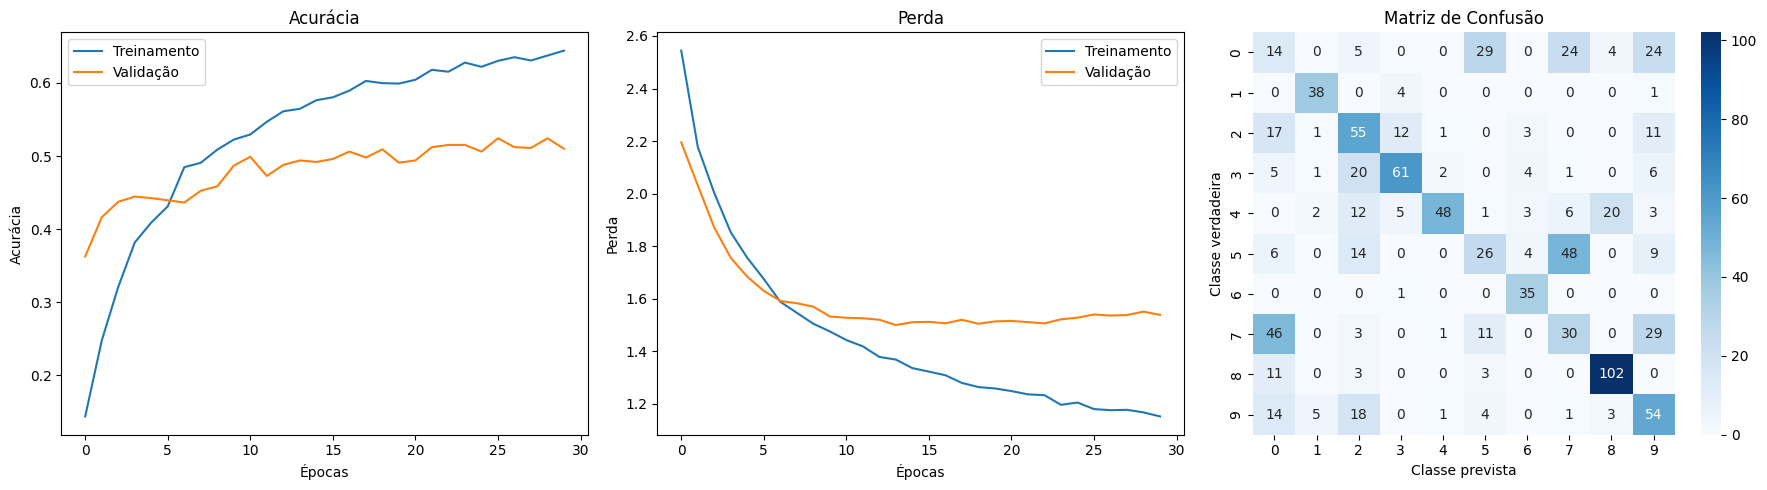

Fold 3: Test accuracy: 0.5005
Processing Fold 4...
Epoch 1/30


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1396 - loss: 2.7576 - val_accuracy: 0.3761 - val_loss: 2.0988
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2464 - loss: 2.1969 - val_accuracy: 0.3889 - val_loss: 1.9244
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3181 - loss: 1.9980 - val_accuracy: 0.4487 - val_loss: 1.7675
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3718 - loss: 1.8563 - val_accuracy: 0.4989 - val_loss: 1.6388
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3988 - loss: 1.7644 - val_accuracy: 0.4915 - val_loss: 1.5684
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4457 - loss: 1.6685 - val_accuracy: 0.5021 - val_loss: 1.5102
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4669 - loss: 1.6021 - val_accuracy: 0.5235 - val_loss: 1.4623
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4810 - loss: 1.5704 - val_accuracy: 0.5192 - val_loss: 1.4388
Epo

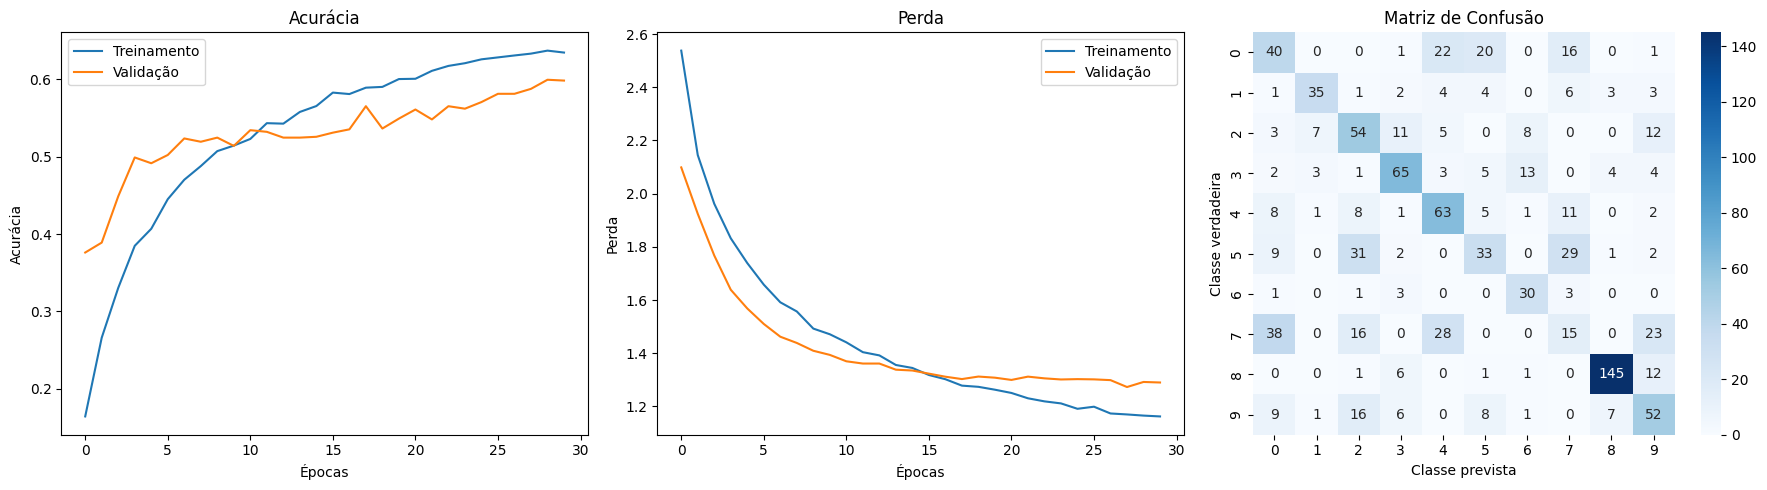

Fold 4: Test accuracy: 0.5374
Processing Fold 5...
Epoch 1/30


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1232 - loss: 2.7352 - val_accuracy: 0.2746 - val_loss: 2.1830
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2582 - loss: 2.1726 - val_accuracy: 0.3402 - val_loss: 2.0214
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3246 - loss: 1.9719 - val_accuracy: 0.3621 - val_loss: 1.9171
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3651 - loss: 1.8623 - val_accuracy: 0.4046 - val_loss: 1.8415
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4031 - loss: 1.7439 - val_accuracy: 0.3961 - val_loss: 1.7844
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4239 - loss: 1.6850 - val_accuracy: 0.4216 - val_loss: 1.7551
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4530 - loss: 1.6161 - val_accuracy: 0.4496 - val_loss: 1.7211
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4803 - loss: 1.5621 - val_accuracy: 0.4362 - val_loss: 1.6946
Epo

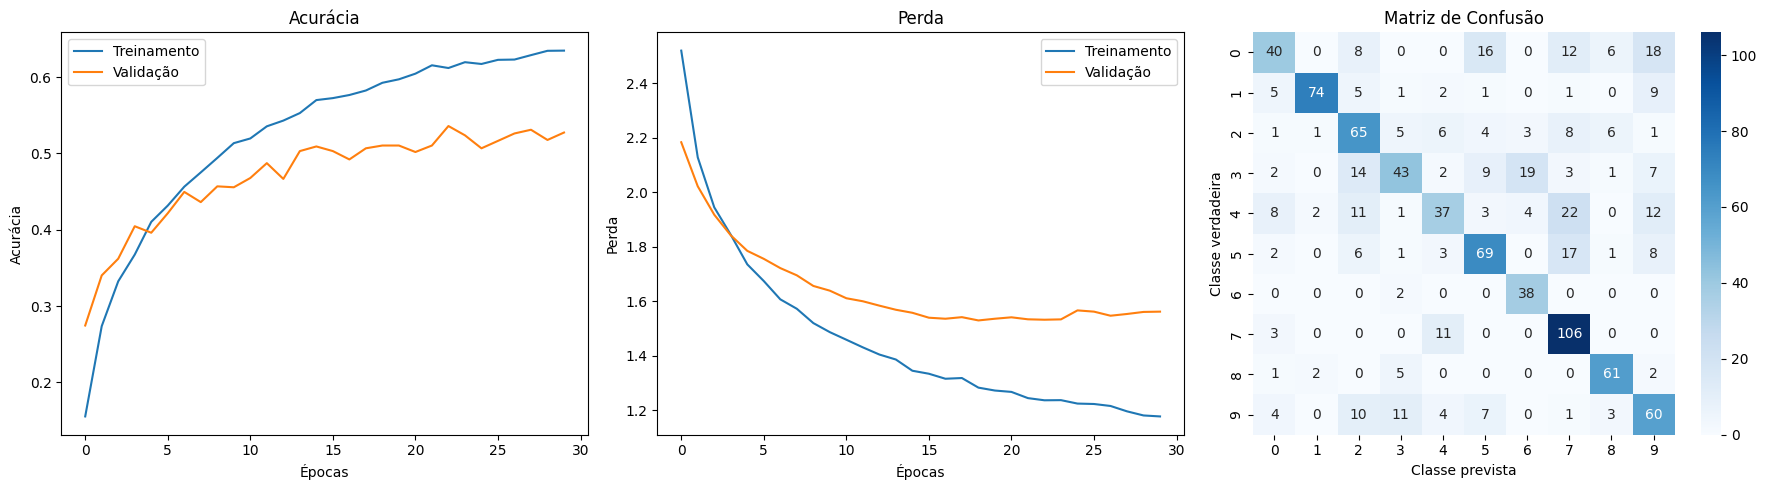

Fold 5: Test accuracy: 0.6335
Processing Fold 6...
Epoch 1/30


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1279 - loss: 2.6179 - val_accuracy: 0.3019 - val_loss: 2.1947
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2530 - loss: 2.1881 - val_accuracy: 0.3305 - val_loss: 2.0281
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3216 - loss: 1.9743 - val_accuracy: 0.3616 - val_loss: 1.8830
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3894 - loss: 1.8003 - val_accuracy: 0.3795 - val_loss: 1.7919
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4352 - loss: 1.6876 - val_accuracy: 0.4069 - val_loss: 1.7339
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4723 - loss: 1.6121 - val_accuracy: 0.4391 - val_loss: 1.6919
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4903 - loss: 1.5564 - val_accuracy: 0.4332 - val_loss: 1.6574
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4997 - loss: 1.5453 - val_accuracy: 0.4535 - val_loss: 1.6457
Epo

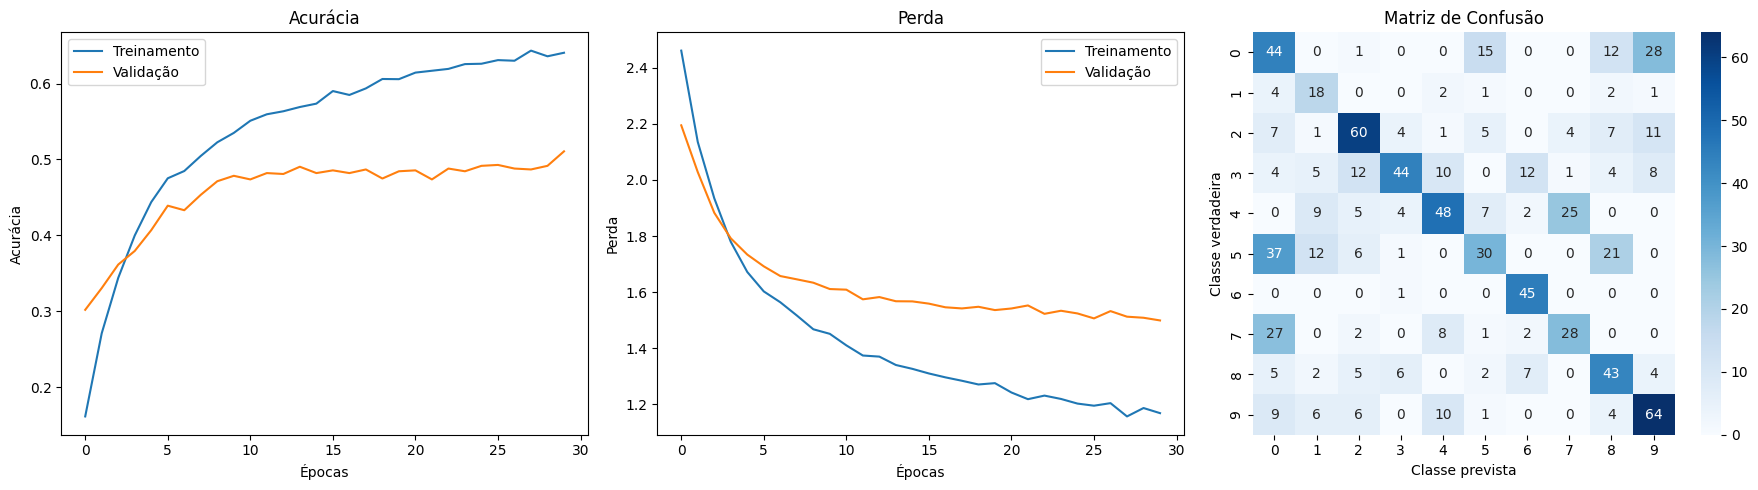

Fold 6: Test accuracy: 0.5152
Processing Fold 7...
Epoch 1/30


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1355 - loss: 2.6536 - val_accuracy: 0.3772 - val_loss: 2.1391
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2412 - loss: 2.1651 - val_accuracy: 0.4355 - val_loss: 1.9019
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3170 - loss: 1.9795 - val_accuracy: 0.4814 - val_loss: 1.7029
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3636 - loss: 1.8734 - val_accuracy: 0.5074 - val_loss: 1.5918
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4107 - loss: 1.7305 - val_accuracy: 0.5223 - val_loss: 1.5307
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4441 - loss: 1.6789 - val_accuracy: 0.5546 - val_loss: 1.4775
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4582 - loss: 1.6355 - val_accuracy: 0.5658 - val_loss: 1.4368
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4701 - loss: 1.5816 - val_accuracy: 0.5720 - val_loss: 1.4320
Epo

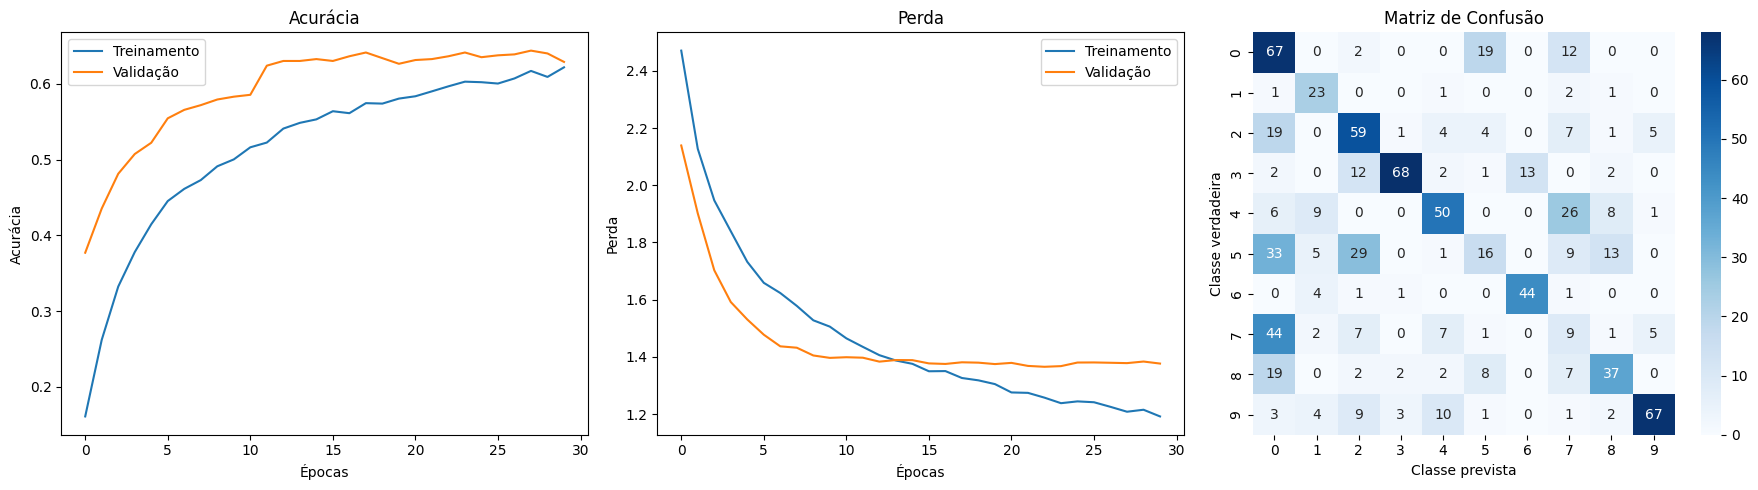

Fold 7: Test accuracy: 0.5251
Processing Fold 8...
Epoch 1/30


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1237 - loss: 2.6940 - val_accuracy: 0.3738 - val_loss: 2.1345
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2239 - loss: 2.2176 - val_accuracy: 0.3701 - val_loss: 1.9299
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3026 - loss: 2.0301 - val_accuracy: 0.3934 - val_loss: 1.7447
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3626 - loss: 1.8787 - val_accuracy: 0.4314 - val_loss: 1.6639
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3906 - loss: 1.7770 - val_accuracy: 0.4449 - val_loss: 1.6135
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4457 - loss: 1.6604 - val_accuracy: 0.4645 - val_loss: 1.5576
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4539 - loss: 1.6198 - val_accuracy: 0.4902 - val_loss: 1.5388
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4789 - loss: 1.5701 - val_accuracy: 0.5086 - val_loss: 1.5171
Epo

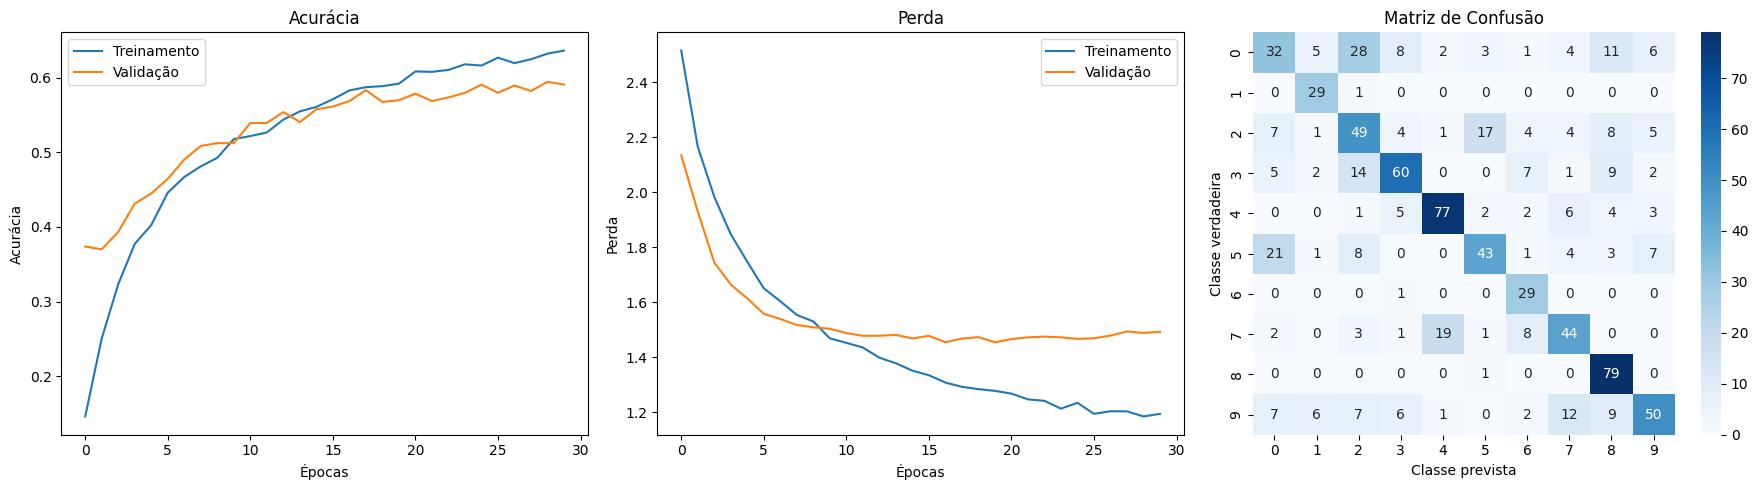

Fold 8: Test accuracy: 0.6104
Processing Fold 9...
Epoch 1/30


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1309 - loss: 2.7076 - val_accuracy: 0.3524 - val_loss: 2.1517
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2398 - loss: 2.1889 - val_accuracy: 0.4146 - val_loss: 1.9761
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3090 - loss: 2.0279 - val_accuracy: 0.4504 - val_loss: 1.8293
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3787 - loss: 1.8577 - val_accuracy: 0.4552 - val_loss: 1.7133
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3973 - loss: 1.7855 - val_accuracy: 0.4779 - val_loss: 1.6542
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4215 - loss: 1.7159 - val_accuracy: 0.4922 - val_loss: 1.6072
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4470 - loss: 1.6522 - val_accuracy: 0.5233 - val_loss: 1.5672
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4711 - loss: 1.5792 - val_accuracy: 0.5102 - val_loss: 1.5418
Epo

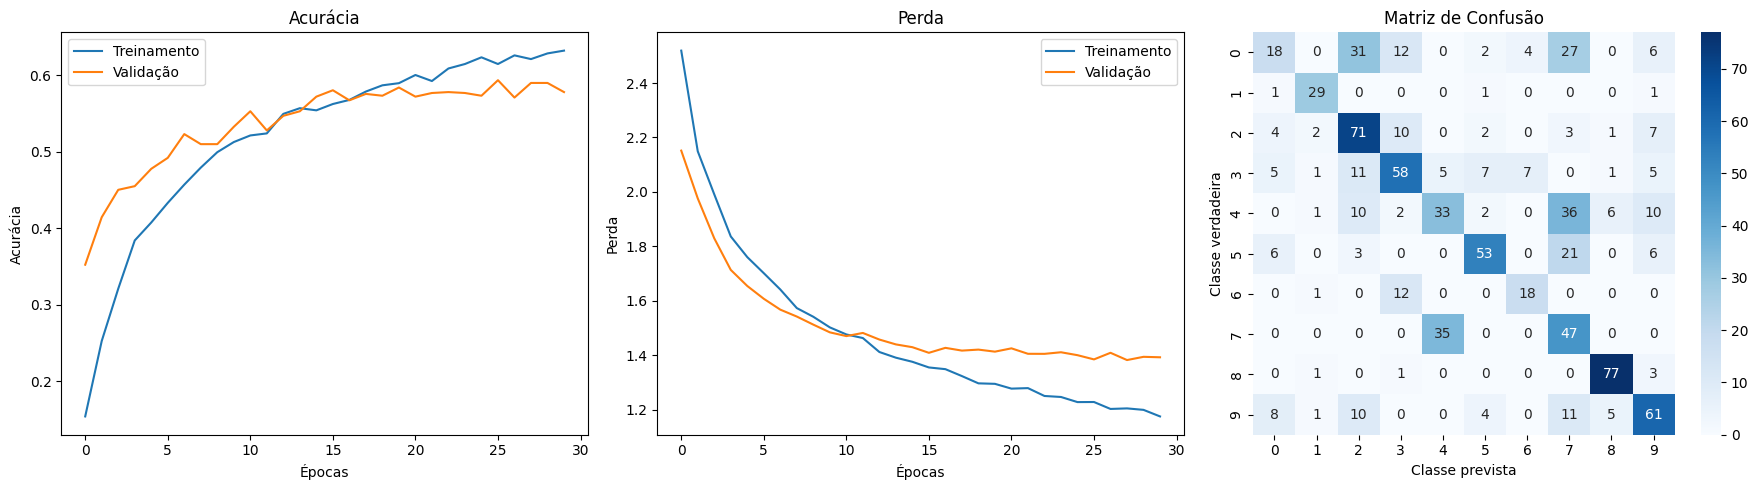

Fold 9: Test accuracy: 0.5699
Processing Fold 10...
Epoch 1/30


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1354 - loss: 2.6343 - val_accuracy: 0.3368 - val_loss: 2.1843
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2418 - loss: 2.1779 - val_accuracy: 0.3975 - val_loss: 1.9865
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3165 - loss: 2.0007 - val_accuracy: 0.4490 - val_loss: 1.8452
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3811 - loss: 1.8470 - val_accuracy: 0.4628 - val_loss: 1.7935
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4117 - loss: 1.7560 - val_accuracy: 0.4719 - val_loss: 1.7631
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4310 - loss: 1.7079 - val_accuracy: 0.4880 - val_loss: 1.7389
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4543 - loss: 1.6234 - val_accuracy: 0.5086 - val_loss: 1.7249
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4778 - loss: 1.5731 - val_accuracy: 0.5086 - val_loss: 1.7155
Epo

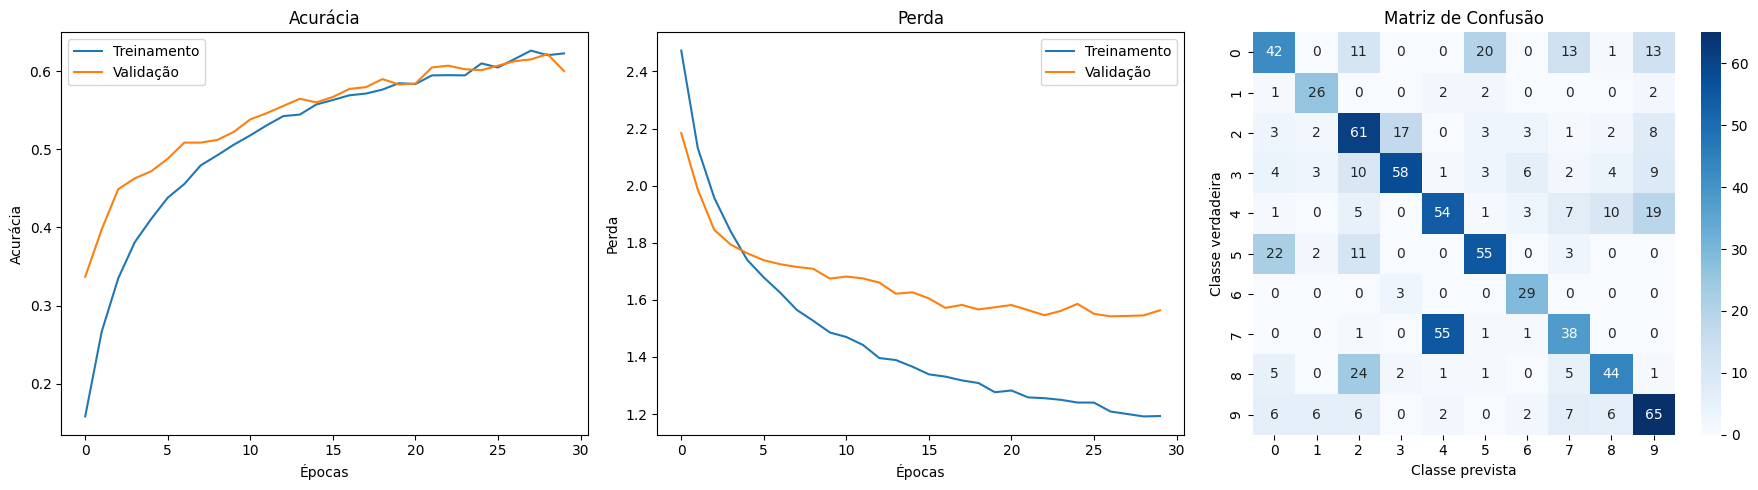

Fold 10: Test accuracy: 0.5639


In [35]:
all_y_true = []
all_y_pred = []
accuracies = []

for test_fold in range(1, 11):
    print(f"Processing Fold {test_fold}...")

    # Dividir os dados entre treino, validação e teste
    test_data = datasets[test_fold - 1]
    X_test = test_data.drop(columns=['Label']).values
    y_test = test_data['Label'].values

    val_fold = (test_fold % 10) + 1  # Fold para validação
    val_data = datasets[val_fold - 1]
    X_val = val_data.drop(columns=['Label']).values
    y_val = val_data['Label'].values

    train_data = pd.concat([datasets[i] for i in range(10) if i not in [test_fold - 1, val_fold - 1]])
    X_train = train_data.drop(columns=['Label']).values
    y_train = train_data['Label'].values

    # Aplicar SMOTE aos dados de treinamento
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_smote = scaler.fit_transform(X_train_smote)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Criar e treinar o modelo
    input_dim = X_train_smote.shape[1]
    model = create_model(input_dim)
    history = model.fit(
        x=X_train_smote,
        y=y_train_smote,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=128,
        verbose=1
    )

    # Fazer previsões
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Acumular valores reais e previstos
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred_classes)

    # Matriz de confusão para o fold atual
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Plotar os gráficos lado a lado
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 linha, 3 colunas

    # Gráfico de acurácia
    axes[0].plot(history.history['accuracy'], label='Treinamento')
    axes[0].plot(history.history['val_accuracy'], label='Validação')
    axes[0].set_title('Acurácia')
    axes[0].set_xlabel('Épocas')
    axes[0].set_ylabel('Acurácia')
    axes[0].legend()

    # Gráfico de perda
    axes[1].plot(history.history['loss'], label='Treinamento')
    axes[1].plot(history.history['val_loss'], label='Validação')
    axes[1].set_title('Perda')
    axes[1].set_xlabel('Épocas')
    axes[1].set_ylabel('Perda')
    axes[1].legend()

    # Matriz de confusão
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[2])
    axes[2].set_title('Matriz de Confusão')
    axes[2].set_xlabel('Classe prevista')
    axes[2].set_ylabel('Classe verdadeira')

    plt.tight_layout()
    plt.show()

    # Exibir a acurácia final do fold
    accuracy = accuracy_score(y_test, y_pred_classes)
    accuracies.append(accuracy)
    print(f"Fold {test_fold}: Test accuracy: {accuracy:.4f}")


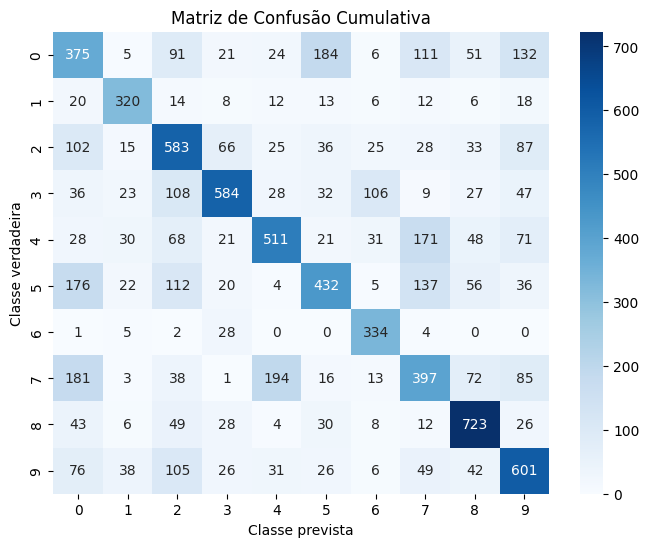

In [36]:
# Criar a matriz de confusão cumulativa após as 10 iterações
cumulative_conf_matrix = confusion_matrix(all_y_true, all_y_pred)

# Plotar a matriz de confusão cumulativa
plt.figure(figsize=(8, 6))
sns.heatmap(cumulative_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão Cumulativa')
plt.xlabel('Classe prevista')
plt.ylabel('Classe verdadeira')
plt.show()

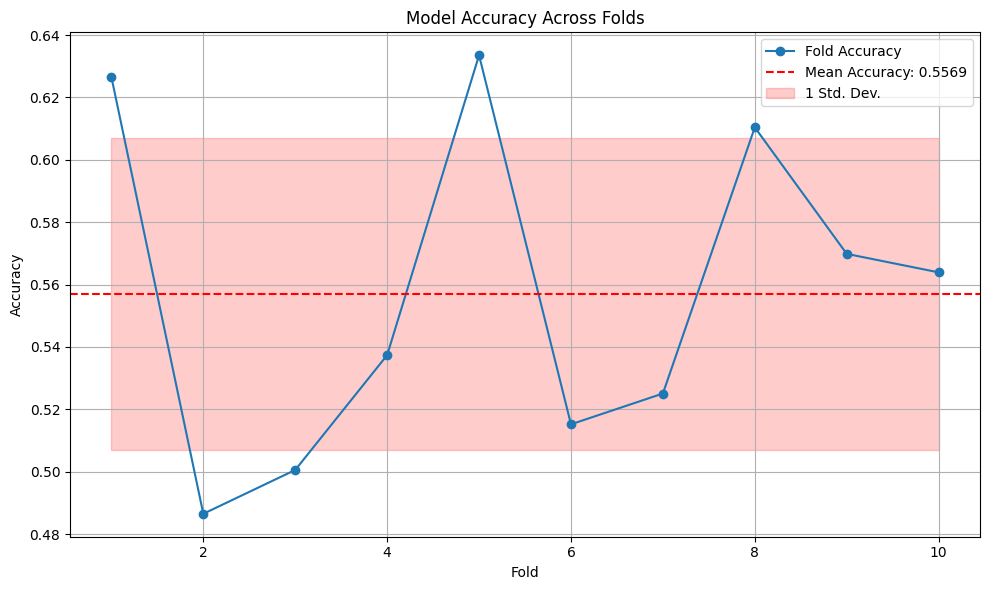

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracies, marker='o', label='Fold Accuracy')
plt.axhline(np.mean(accuracies), color='r', linestyle='--', label=f'Mean Accuracy: {np.mean(accuracies):.4f}')
plt.fill_between(range(1, 11),
                 np.mean(accuracies) - np.std(accuracies),
                 np.mean(accuracies) + np.std(accuracies),
                 color='r', alpha=0.2, label='1 Std. Dev.')
plt.title("Model Accuracy Across Folds")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()